In [1]:
# Pathway stats
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import itertools

In [25]:
KEGG_pathway_df = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]
Metacyc_human_pathways = pd.read_csv("Metacyc_human_pathways.csv", dtype=str, index_col=0)

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)
metacyc_pathway_dict = process_paths(Metacyc_human_pathways)

In [26]:
print(len(KEGG_pathway_dict))
print(len(Reactome_pathway_dict))

261
1631


20.0
DescribeResult(nobs=261, minmax=(3, 333), mean=29.582375478927204, variance=1134.4903035661655, skewness=3.742718855042164, kurtosis=25.19812224720515)
8.0
DescribeResult(nobs=1631, minmax=(3, 1616), mean=18.83629675045984, variance=3004.638828976916, skewness=17.980384131478196, kurtosis=464.25872088154836)


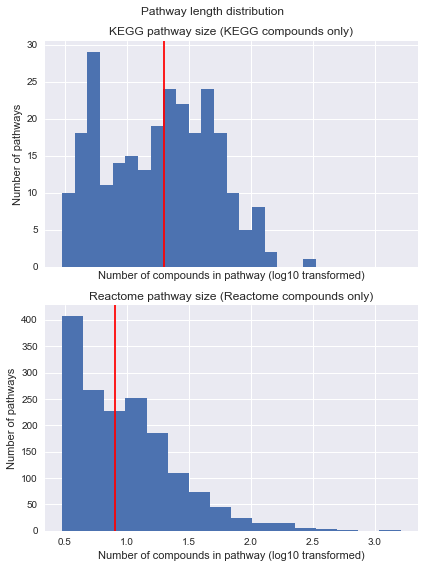

In [34]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
print(np.median(pathway_length_KEGG))
print(stats.describe(pathway_length_KEGG))
plt.style.use("seaborn")
plt.suptitle("Pathway length distribution")
ax1.hist(np.log10(pathway_length_KEGG), bins=20)
ax1.axvline(np.log10(np.median(pathway_length_KEGG)), c="r")
ax1.set_title("KEGG pathway size (KEGG compounds only)")
ax1.set_ylabel("Number of pathways")
ax1.set_xlabel("Number of compounds in pathway (log10 transformed)")

pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
print(np.median(pathway_length_Reactome))
print(stats.describe(pathway_length_Reactome))
ax2.hist(np.log10(pathway_length_Reactome), bins=16)
ax2.axvline(np.log10(np.median(pathway_length_Reactome)), c="r")
ax2.set_title("Reactome pathway size (Reactome compounds only)")
ax2.set_ylabel("Number of pathways")
ax2.set_xlabel("Number of compounds in pathway (log10 transformed)")
# plt.savefig("../Figures/pathway_size_comparison.png", dpi=300)
plt.tight_layout()

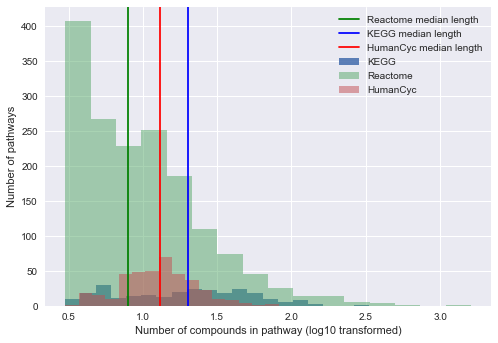

In [35]:
# Overlay hists
pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
pathway_length_metacyc = [len(v) for k, v in metacyc_pathway_dict.items()]
plt.style.use("seaborn")
plt.hist(np.log10(pathway_length_KEGG), bins=20, alpha=0.9, label="KEGG")
plt.axvline(np.log10(np.median(pathway_length_Reactome)), c="green", label="Reactome median length")
plt.hist(np.log10(pathway_length_Reactome), bins=16, alpha=0.5, label="Reactome")
plt.axvline(np.log10(np.median(pathway_length_KEGG)), c="blue", label="KEGG median length")
plt.hist(np.log10(pathway_length_metacyc), bins=16, alpha=0.5, label="HumanCyc")
plt.axvline(np.log10(np.median(pathway_length_metacyc)), c="red", label="HumanCyc median length")
plt.ylabel("Number of pathways")
plt.xlabel("Number of compounds in pathway (log10 transformed)")

plt.legend()
plt.savefig("../Figures/pathway_length_disctribution.png", dpi=600)
plt.show()

In [32]:
# Pathway overlap
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

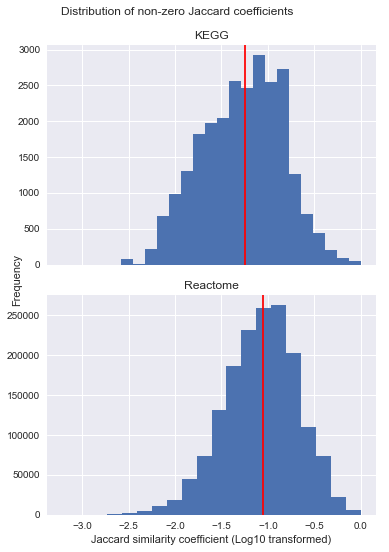

In [33]:
all_pathways_KEGG = [k for k, v in KEGG_pathway_dict.items()]
all_pathways_reactome = [k for k, v in Reactome_pathway_dict.items()]
jaccard_similarity_list_KEGG = []
jaccard_similarity_list_reactome = []
for pathway_pair in itertools.permutations(all_pathways_KEGG,2):
    jaccard_similarity_list_KEGG.append(jaccard_similarity(KEGG_pathway_dict[pathway_pair[0]], KEGG_pathway_dict[pathway_pair[1]]))
for pathway_pair in itertools.permutations(all_pathways_reactome,2):
    jaccard_similarity_list_reactome.append(jaccard_similarity(Reactome_pathway_dict[pathway_pair[0]], Reactome_pathway_dict[pathway_pair[1]]))

jaccard_non_zero_kegg = [i for i in jaccard_similarity_list_KEGG if i != 0]
jaccard_non_zero_reactome = [i for i in jaccard_similarity_list_reactome if i != 0]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

ax1.hist(np.log10(jaccard_non_zero_kegg), bins=20)
ax1.set_title("KEGG")
ax1.axvline(np.log10(np.median(jaccard_non_zero_kegg)), c="r")
ax2.hist(np.log10(jaccard_non_zero_reactome), bins=20)
ax2.set_title("Reactome")
ax2.axvline(np.log10(np.median(jaccard_non_zero_reactome)), c="r")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Jaccard similarity coefficient (Log10 transformed)')
plt.ylabel('Frequency')
plt.suptitle('Distribution of non-zero Jaccard coefficients')
plt.tight_layout()
# plt.savefig("../Figures/pathway_overlap_comparison.png", dpi=300)
plt.show()

## Pathway db results comparison

In [61]:
DEM_auwerx_r, background_auwerx_r, mat_auwerx_r = process_datasets.auwerx_data(db="Reactome")
DEM_yamada_r, background_yamada_r, mat_yamada_r = process_datasets.yamada_data(db="Reactome")
DEM_stevens_r, background_stevens_r, mat_stevens_r = process_datasets.stevens_data(db="Reactome")
DEM_brown_r, background_brown_r, mat_brown_r = process_datasets.brown_data(db="Reactome")
DEM_yfgM_r, background_yfgM_r, mat_yfgM_r = process_datasets.zamboni_data("yfgM", db="Reactome")
DEM_dcuS_r, background_dcuS_r, mat_dcuS_r = process_datasets.zamboni_data("dcuS", db="Reactome")

# Import KEGG datasets
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import BioCyc datasets
DEM_auwerx_b, background_auwerx_b, mat_auwerx_b = process_datasets.auwerx_data(db="Cyc")
DEM_yamada_b, background_yamada_b, mat_yamada_b = process_datasets.yamada_data(db="Cyc")
DEM_stevens_b, background_stevens_b, mat_stevens_b = process_datasets.stevens_data(db="Cyc")
DEM_brown_b, background_brown_b, mat_brown_b = process_datasets.brown_data(db="Cyc")
DEM_yfgM_b, background_yfgM_b, mat_yfgM_b = process_datasets.zamboni_data("yfgM", db="Cyc")
DEM_dcuS_b, background_dcuS_b, mat_dcuS_b = process_datasets.zamboni_data("dcuS", db="Cyc")

# Import KEGG pathway sets
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# Import Reactome pathway sets
Reactome_pathways = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("HSA")]
Reactome_eco_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("ECO")]
Reactome_mouse_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("MMU")]
all_reactome_human_bg = list(set([x for x in Reactome_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_reactome_mouse_bg = list(set([x for x in Reactome_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# Import BioCyc pathway sets
BioCyc_human_pathways = pd.read_csv("Metacyc_human_pathways.csv", dtype=str, index_col=0)
BioCyc_eco_pathways = pd.read_csv("Metacyc_EColi_pathways.csv", dtype=str, index_col=0)
all_biocyc_human_bg = list(set([x for x in BioCyc_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_biocyc_eco_bg = list(set([x for x in BioCyc_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

datasets = {"Labbé": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg],
            "Yachida": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg],
            "Quirós": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg],
            "Fuhrer (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg],
            "Fuhrer (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg]}

datasets_reactome = {
    "Labbé": [DEM_brown_r, background_brown_r, Reactome_mouse_pathways, all_reactome_mouse_bg],
    "Yachida": [DEM_yamada_r, background_yamada_r, Reactome_human_pathways, all_reactome_human_bg],
    "Stevens": [DEM_stevens_r, background_stevens_r, Reactome_human_pathways, all_reactome_human_bg],
    "Quirós": [DEM_auwerx_r, background_auwerx_r, Reactome_human_pathways, all_reactome_human_bg],
    "Fuhrer (yfgM)": [DEM_yfgM_r, background_yfgM_r, Reactome_human_pathways, all_reactome_human_bg],
    "Fuhrer (dcuS)": [DEM_dcuS_r, background_dcuS_r, Reactome_human_pathways, all_reactome_human_bg]}

datasets_biocyc = {"Labbé": [DEM_brown_b, background_brown_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Yachida": [DEM_yamada_b, background_yamada_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Stevens": [DEM_stevens_b, background_stevens_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Quirós": [DEM_auwerx_b, background_auwerx_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Fuhrer (yfgM)": [DEM_yfgM_b, background_yfgM_b, BioCyc_eco_pathways, all_biocyc_eco_bg],
                   "Fuhrer (dcuS)": [DEM_dcuS_b, background_dcuS_b, BioCyc_eco_pathways, all_biocyc_eco_bg]}

print("Data processing complete.")

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Data processing complete.


In [62]:
db_dict = {"KEGG": datasets, "Reactome": datasets_reactome, "BioCyc": datasets_biocyc}
results_dicts = dict.fromkeys(db_dict.keys(), {})
for d in db_dict.keys():
    d_set = db_dict[d]
    res_datasets = {}
    for i in d_set.keys():
        ora_res = utils.over_representation_analysis(d_set[i][0], d_set[i][1], d_set[i][2])
        significant_ids = ora_res[ora_res["P-value"] <= 0.1]["Pathway_ID"]
        res_datasets[i] = significant_ids.tolist()
    results_dicts[d] = res_datasets
        

257
261
261
261
105
105
1091
1631
1631
1631
1631
1631
386
386
386
386
437
437


In [16]:
# convert all IDS to KEGG
from bioservices import *


In [17]:
# get reactome ChEBI compounds for each pathway
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

Reactome_pathways = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_pathways = process_paths(Reactome_pathways)


In [18]:
ch = ChEBI()

reactome_sig_path_cpds = {}

for name, v in results_dicts["Reactome"].items():
    pathways = v
    all_compounds_in_pathways = []
    for pathway in pathways:
        pathway_compounds = Reactome_pathways[pathway]
        pathway_compounds_kegg = []
        for cpd in pathway_compounds:
            try:
                kegg_id = ch.conv("CHEBI:"+cpd, "KEGG COMPOUND accession")
                pathway_compounds_kegg.append(kegg_id[0])
            except (ValueError, AttributeError):
                continue
        print(pathway, len(pathway_compounds), len(pathway_compounds_kegg))
        all_compounds_in_pathways = all_compounds_in_pathways + pathway_compounds_kegg
    reactome_sig_path_cpds[name] = list(set(all_compounds_in_pathways))
    
print(reactome_sig_path_cpds.keys())

R-MMU-381771 21 18
R-MMU-400508 21 18
R-MMU-416476 64 51
R-MMU-71288 12 8
R-MMU-73614 23 19
R-HSA-141334 11 11
R-HSA-1483152 9 8
R-HSA-163560 22 15
R-HSA-194138 35 27
R-HSA-202131 26 20
R-HSA-203615 26 20
R-HSA-392154 19 12
R-HSA-418346 40 29
R-HSA-4420097 35 27
R-HSA-5218920 17 13
R-HSA-6799990 7 5
R-HSA-75109 19 11
R-HSA-8979227 37 22
R-HSA-917937 24 18
R-HSA-114508 15 11
R-HSA-162582 403 280
R-HSA-212436 72 49
R-HSA-2262752 77 50
R-HSA-2990846 16 12
R-HSA-3108232 10 8
R-HSA-389661 43 28
R-HSA-4090294 9 7
R-HSA-416476 67 54
R-HSA-425393 57 32
R-HSA-426048 8 7
R-HSA-73857 79 52
R-HSA-74160 104 68
R-HSA-8953897 80 52
R-HSA-9614085 18 10
R-HSA-113418 5 3
R-HSA-1222556 52 31
R-HSA-1428517 66 49
R-HSA-1430728 1616 1005
R-HSA-156580 149 106
R-HSA-156581 39 31
R-HSA-156584 47 33
R-HSA-156588 31 19
R-HSA-156590 30 20
R-HSA-157118 17 10
R-HSA-157579 22 15
R-HSA-15869 157 118
R-HSA-1614517 20 15
R-HSA-1614558 49 34
R-HSA-1614635 83 56
R-HSA-1630316 61 26
R-HSA-1638074 19 13
R-HSA-1638091 34 18

In [86]:
for k, v in reactome_sig_path_cpds.items():
    print(k, v)

Labbé ['C01996', 'C00249', 'C00712', 'C04230', 'C00267', 'C06427', 'C01712', 'C06429', 'C06428', 'C06426', 'C08362', 'C06424', 'C02679', 'C16537', 'C16522', 'C03242', 'C16527', 'C16513', 'C01996', 'C00033', 'C00080', 'C00584', 'C00639', 'C02198', 'C02165', 'C05952', 'C00075', 'C00077', 'C00249', 'C00355', 'C00044', 'C00712', 'C01245', 'C02166', 'C01585', 'C00035', 'C00015', 'C00641', 'C00388', 'C04637', 'C00547', 'C06427', 'C01712', 'C06429', 'C06428', 'C06426', 'C05951', 'C08362', 'C00780', 'C06424', 'C00788', 'C00038', 'C00076', 'C00205', 'C00058', 'C00163', 'C00246', 'C02679', 'C16537', 'C16522', 'C03242', 'C16527', 'C16513', 'C06314', 'C00114', 'C00080', 'C00086', 'C00791', 'C03642', 'C00115', 'C01330', 'C11310', 'C07151', 'C07401', 'C00080', 'C00019', 'C00077', 'C00581', 'C00021', 'C00300', 'C02305', 'C01330', 'C00001', 'C00881', 'C00239', 'C00526', 'C00105', 'C00299', 'C00364', 'C00055', 'C00475', 'C00106', 'C00365', 'C00214', 'C02067', 'C00178', 'C01168', 'C00305', 'C00672', 'C0

In [19]:
KEGG_human_pathways = process_paths(pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0))
KEGG_eco_pathways = process_paths(pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0))
KEGG_mouse_pathways = process_paths(pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0))
kegg_pathways_merged = {**KEGG_human_pathways, **KEGG_eco_pathways}
all_kegg_pathways_merged = {**kegg_pathways_merged, **KEGG_mouse_pathways}

kegg_sig_path_cpds = {}

for name, v in results_dicts["KEGG"].items():
    pathways = v
    all_compounds_in_pathways = []
    for pathway in pathways:
        pathway_compounds = all_kegg_pathways_merged[pathway]
        print(pathway, len(pathway_compounds))
        all_compounds_in_pathways = all_compounds_in_pathways + pathway_compounds
    kegg_sig_path_cpds[name] = list(set(all_compounds_in_pathways))

mmu00220 23
mmu00240 70
mmu00260 50
mmu00471 13
mmu00564 56
mmu00591 30
mmu00730 32
mmu00970 52
mmu01040 122
mmu01210 134
mmu01230 129
mmu04217 13
mmu04724 23
mmu04727 20
mmu04921 19
mmu04974 46
mmu05030 32
mmu05031 44
mmu05143 8
hsa00130 73
hsa00280 47
hsa00290 23
hsa00350 79
hsa00400 34
hsa00630 65
hsa00970 52
hsa01210 134
hsa01230 129
hsa01240 333
hsa04916 6
hsa05131 16
hsa05230 55
hsa00071 57
hsa00260 50
hsa01040 122
hsa04714 30
hsa04923 22
hsa00030 38
hsa00040 56
hsa00051 56
hsa00052 48
hsa00053 50
hsa00220 23
hsa00230 102
hsa00240 70
hsa00250 29
hsa00260 50
hsa00270 66
hsa00280 47
hsa00330 78
hsa00340 47
hsa00410 32
hsa00430 22
hsa00471 13
hsa00480 42
hsa00520 117
hsa00524 83
hsa00620 31
hsa00630 65
hsa00650 42
hsa00740 20
hsa00760 55
hsa00770 30
hsa00860 140
hsa00920 48
hsa00970 52
hsa00980 121
hsa01200 108
hsa01210 134
hsa01230 129
hsa01240 333
hsa02010 115
hsa04022 17
hsa04068 5
hsa04080 45
hsa04122 21
hsa04150 4
hsa04152 25
hsa04216 39
hsa04727 20
hsa04742 35
hsa04918 48
hsa0

In [43]:
print(kegg_sig_path_cpds.keys())

dict_keys(['Labbé', 'Yachida', 'Stevens', 'Quirós', 'Fuhrer (yfgM)', 'Fuhrer (dcuS)'])


In [20]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [153]:
def overlap_coefficient(list1, list2):
    # Szymkiewicz–Simpson coefficient
    intersection = len(list(set(list1).intersection(list2)))
    smaller_set = min(len(list1), len(list2))
    return float(intersection) / smaller_set

In [158]:
def sorensen_dice_coefficient(list1, list2):
    # Sørensen–Dice coefficient
    intersection = len(list(set(list1).intersection(list2)))
    total_Set_size = len(list1) + len(list2)
    return float(2*intersection) / total_Set_size

0.08034188034188035
0.02890932982917214
0.10465116279069768
0.185473411154345
0.10366972477064221
0.11707317073170732


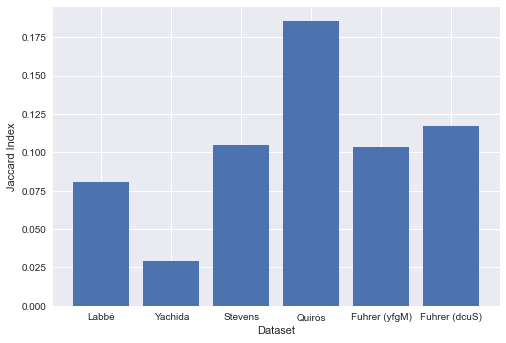

In [123]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = jaccard_similarity(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    res[dset] = JI
    print(JI)

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("Jaccard Index")
plt.show()

0.618421052631579
0.30985915492957744
0.234375
0.411313518696069
0.29736842105263156
0.33410672853828305


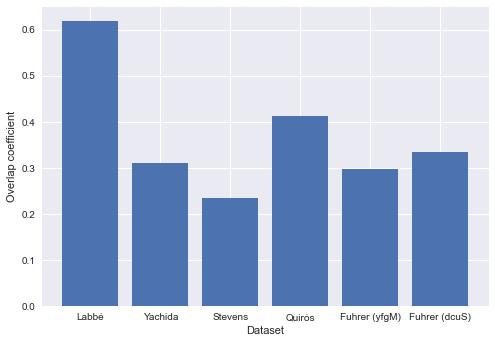

In [157]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = overlap_coefficient(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    print(JI)
    res[dset] = JI

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("Overlap coefficient")
plt.show()

0.14873417721518986
0.0561941251596424
0.18947368421052632
0.31291028446389496
0.18786367414796343
0.2096069868995633


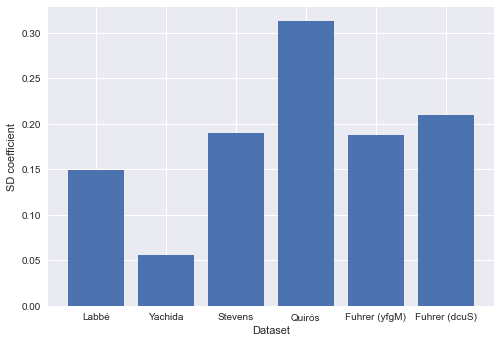

In [159]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = sorensen_dice_coefficient(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    print(JI)
    res[dset] = JI

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("SD coefficient")
plt.show()

In [52]:
db_dict = {"KEGG": datasets, "Reactome": datasets_reactome, "BioCyc": datasets_biocyc}
results_dicts = dict.fromkeys(db_dict.keys(), {})
for d in db_dict.keys():
    d_set = db_dict[d]
    res_datasets = {}
    for i in d_set.keys():
        ora_res = utils.over_representation_analysis(d_set[i][0], d_set[i][1], d_set[i][2])
        significant_ids = ora_res[ora_res["P-value"] <= 0.1]["Pathway_name"]
        print(d, i, significant_ids.tolist())
        print()
        res_datasets[i] = significant_ids.tolist()
    results_dicts[d] = res_datasets
        

KEGG Labbé ['Arginine biosynthesis - Mus musculus (mouse)', 'Pyrimidine metabolism - Mus musculus (mouse)', 'Glycine, serine and threonine metabolism - Mus musculus (mouse)', 'D-Glutamine and D-glutamate metabolism - Mus musculus (mouse)', 'Glycerophospholipid metabolism - Mus musculus (mouse)', 'Linoleic acid metabolism - Mus musculus (mouse)', 'Thiamine metabolism - Mus musculus (mouse)', 'Aminoacyl-tRNA biosynthesis - Mus musculus (mouse)', 'Biosynthesis of unsaturated fatty acids - Mus musculus (mouse)', '2-Oxocarboxylic acid metabolism - Mus musculus (mouse)', 'Biosynthesis of amino acids - Mus musculus (mouse)', 'Necroptosis - Mus musculus (mouse)', 'Glutamatergic synapse - Mus musculus (mouse)', 'GABAergic synapse - Mus musculus (mouse)', 'Oxytocin signaling pathway - Mus musculus (mouse)', 'Protein digestion and absorption - Mus musculus (mouse)', 'Cocaine addiction - Mus musculus (mouse)', 'Amphetamine addiction - Mus musculus (mouse)', 'African trypanosomiasis - Mus musculus 

Reactome Labbé ['Synthesis, secretion, and inactivation of Glucagon-like Peptide-1 (GLP-1)', 'Incretin synthesis, secretion, and inactivation', 'G alpha (q) signalling events', 'Creatine metabolism', 'Pyrimidine salvage']

Reactome Yachida ['PAOs oxidise polyamines to amines', 'Hydrolysis of LPE', 'Triglyceride catabolism', 'Signaling by VEGF', 'Metabolism of nitric oxide: NOS3 activation and regulation', 'eNOS activation', 'Nitric oxide stimulates guanylate cyclase', 'Platelet homeostasis', 'VEGFA-VEGFR2 Pathway', 'VEGFR2 mediated vascular permeability', 'Metal sequestration by antimicrobial proteins', 'Triglyceride biosynthesis', 'Triglyceride metabolism', 'Iron uptake and transport']

Reactome Stevens ['Effects of PIP2 hydrolysis', 'Signal Transduction', 'Generic Transcription Pathway', 'Cellular responses to stress', 'SUMOylation', 'SUMO E3 ligases SUMOylate target proteins', 'Glyoxylate metabolism and glycine degradation', 'SUMOylation of intracellular receptors', 'G alpha (q) sig

Reactome Fuhrer (dcuS) ['Neurotransmitter release cycle', 'Synthesis of CL', 'Synthesis of PE', 'Glycosaminoglycan metabolism', 'Keratan sulfate/keratin metabolism', 'Disease', 'Sphingolipid de novo biosynthesis', 'Digestion of dietary carbohydrate', 'Peptide hormone metabolism', 'Amino acid transport across the plasma membrane', 'Metabolism of proteins', 'Sialic acid metabolism', 'cGMP effects', 'Transport of vitamins, nucleosides, and related molecules', 'Sphingolipid metabolism', 'Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein', 'Asparagine N-linked glycosylation', 'Synthesis of UDP-N-acetyl-glucosamine', 'Synthesis of substrates in N-glycan biosythesis', 'Variant SLC6A14 may confer susceptibility towards obesity', 'SLC transporter disorders', 'Defective SLC27A4 causes ichthyosis prematurity syndrome (IPS)', 'Disorders of transmembrane transporters', 'Intestinal saccharidase deficiencies', 'Diseases of carbohydra

In [121]:
# all kegg significant pathway compounds
Reactome_pathways = pd.read_csv("Reactome_pathway_set.csv", dtype=str, index_col=0)
Reactome_mouse_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("MMU")]
Reactome_pathways = process_paths(Reactome_mouse_pathways)
ch = ChEBI()

reactome_sig_path_cpds = {}

Reactome_pathways_toKEGG = {}

# Labbe dataset only
pathways = list(Reactome_pathways.keys())
for pathway in pathways:
    pathway_compounds = Reactome_pathways[pathway]
    pathway_compounds_kegg = []
    for cpd in pathway_compounds:
        try:
            kegg_id = ch.conv("CHEBI:" + cpd, "KEGG COMPOUND accession")
            pathway_compounds_kegg.append(kegg_id[0])
        except (ValueError, AttributeError):
            continue
    Reactome_pathways_toKEGG[pathway] = pathway_compounds_kegg

print("Done.")

(1096, 96)
Done.


In [11]:
import pickle

# with open('Reactome_pathways_toKEGG_MMU.pickle', 'wb') as handle:
#     pickle.dump(Reactome_pathways_toKEGG, handle, protocol=pickle.HIGHEST_PROTOCOL
                
with open('Reactome_pathways_toKEGG_MMU.pickle', 'rb') as handle:
    Reactome_pathways_toKEGG = pickle.load(handle)

In [12]:
labbe_all_kegg_sig_pathway_cpds = set(kegg_sig_path_cpds["Labbé"])
# discard pathways which have no compounds in common
keep_reactome_paths = []
for k, v in Reactome_pathways_toKEGG.items():
    kegg_overlap = len(labbe_all_kegg_sig_pathway_cpds.intersection(set(v)))
    if kegg_overlap != 0:
        keep_reactome_paths.append(k)
        
print(len(keep_reactome_paths))

453


In [23]:
Reactome_pathways_toKEGG_filt = {k: v for k, v in Reactome_pathways_toKEGG.items() if k in keep_reactome_paths}
Reactome_pathway_JI = {}
for k, v in Reactome_pathways_toKEGG_filt.items():
    print(v)
    JI = jaccard_similarity(set(v), set(kegg_sig_path_cpds["Labbé"]))
    Reactome_pathway_JI[k] = JI

['C00458', 'C04283', 'C00013']
['C00429', 'C00106', 'C00178', 'C06502']
['C00076']
['C00076']
['C00001', 'C00020', 'C00575', 'C00076']
['C00001', 'C00219', 'C00157', 'C04230', 'C00076']
['C00001', 'C00044', 'C01245', 'C00035', 'C00165', 'C04637']
['C00001', 'C00249', 'C00219', 'C00189', 'C00712', 'C11695', 'C06424', 'C02679', 'C16512']
['C00115', 'C00780', 'C01330', 'C00238', 'C00076']
['C00075', 'C00044', 'C00063']
['C01245', 'C00641', 'C00076']
['C00641', 'C02737', 'C00076']
['C00044', 'C01245', 'C05981', 'C00035', 'C00641', 'C04637']
['C00044', 'C00035', 'C00305', 'C00780', 'C00076', 'C00013']
['C00641', 'C02737', 'C00076']
['C00044', 'C00035', 'C00641']
['C00080', 'C00007', 'C00044', 'C00327', 'C00005', 'C00533', 'C00006', 'C00704', 'C14818', 'C00038']
['C00007', 'C00011', 'C00026', 'C14818', 'C00072']
['C00007', 'C00011', 'C00026', 'C14818', 'C00072']
['C00080', 'C00007', 'C00005', 'C00006', 'C00704']
['C00001', 'C00080', 'C00007', 'C00011', 'C00288', 'C00032', 'C00115', 'C00038']

In [22]:
sorted_Reactome_pathway_JI = {k: v for k, v in sorted(Reactome_pathway_JI.items(), key=lambda item: item[1], reverse=True)}

{'R-MMU-416476': 0.04152249134948097,
 'R-MMU-73621': 0.037037037037037035,
 'R-MMU-499943': 0.031141868512110725,
 'R-MMU-73614': 0.028622540250447227,
 'R-MMU-1483191': 0.023214285714285715,
 'R-MMU-381771': 0.021352313167259787,
 'R-MMU-2046106': 0.02112676056338028,
 'R-MMU-1660661': 0.021052631578947368,
 'R-MMU-197264': 0.02097902097902098,
 'R-MMU-1483213': 0.01971326164874552,
 'R-MMU-1483166': 0.01950354609929078,
 'R-MMU-8850843': 0.019434628975265017,
 'R-MMU-500753': 0.01601423487544484,
 'R-MMU-2046105': 0.015957446808510637,
 'R-MMU-977347': 0.01436265709156194,
 'R-MMU-1482798': 0.014336917562724014,
 'R-MMU-75105': 0.014134275618374558,
 'R-MMU-83936': 0.014109347442680775,
 'R-MMU-71403': 0.014084507042253521,
 'R-MMU-75876': 0.014084507042253521,
 'R-MMU-389661': 0.013986013986013986,
 'R-MMU-71064': 0.013986013986013986,
 'R-MMU-1660662': 0.01386481802426343,
 'R-MMU-418594': 0.013136288998357963,
 'R-MMU-71288': 0.012567324955116697,
 'R-MMU-936837': 0.0125448028673

In [164]:
reactome_cpds_added = []
for k, v in sorted_Reactome_pathway_JI.items():
    pathway_cpds = Reactome_pathways_toKEGG[k]
    reactome_cpds_added = reactome_cpds_added + pathway_cpds
    JI = jaccard_similarity(set(reactome_cpds_added), set(kegg_sig_path_cpds["Quirós"]))
    print(JI)

# import itertools

# lst = keep_reactome_paths
# combs = []

# for i in range(1, len(lst)+1):
#     els = [list(x) for x in itertools.combinations(lst, i)]
#     combs.extend(els)

0.013945380592678676
0.027793862188766647
0.039884393063583816
0.041040462427745665
0.04440599769319493
0.044956772334293946
0.046444954128440366
0.047212741751990896
0.05221339387060159
0.05328798185941043
0.05596382136800452
0.05765969474279254
0.06218202374222725
0.06253521126760564
0.0647887323943662
0.06471581316826111
0.06692913385826772
0.0719910011248594
0.07247191011235955
0.07278835386338185
0.07718120805369127
0.07919687674288901
0.08245711123408965
0.08423913043478261
0.08586956521739131
0.08690928843020097
0.08888888888888889
0.0910569105691057
0.0915989159891599
0.09253246753246754
0.09415584415584416
0.09577922077922078
0.0957274202271498
0.09621621621621622
0.09675675675675675
0.09670448406266882
0.09724473257698542
0.097784981091302
0.09935205183585313
0.1009719222462203
0.1025364274150027
0.10517799352750809
0.10721982758620689
0.11039310716208939
0.11135018827326519
0.11117078410311493
0.11654135338345864
0.11654135338345864
0.11654135338345864
0.11654135338345864
0.

## Add in genes to pathways and compare similarity

In [96]:
#combine reactome genes with metabolite pathways
reactome_geneset = pd.read_csv("../ReactomePathways.txt", sep="\t", dtype="str", header=None)
reactome_geneset = reactome_geneset.rename(columns={0: "Pathway_name", 1: "ID"})
reactome_geneset = reactome_geneset.set_index("ID")

In [99]:
reactome_genes_all = process_paths(reactome_geneset)

In [149]:
# stevens data test
significant_paths = results_dicts["Reactome"]["Quirós"]
significant_genes = [v for k, v in reactome_genes_all.items() if k in significant_paths]
reactome_genes_compounds_stevens = reactome_sig_path_cpds["Quirós"] + [item for sublist in significant_genes for item in sublist]
reactome_genes_compounds_stevens

['C03878',
 'C00836',
 'C05455',
 'C01061',
 'C16528',
 'C02984',
 'C01652',
 'C07398',
 'C04006',
 'C00584',
 'C00451',
 'C11481',
 'C15614',
 'C01036',
 'C00032',
 'C01188',
 'C00319',
 'C01222',
 'C00696',
 'C01086',
 'C00096',
 'C00527',
 'C00337',
 'C06125',
 'C04734',
 'C13650',
 'C03205',
 'C00237',
 'C01647',
 'C01453',
 'C05467',
 'C00986',
 'C03508',
 'C18178',
 'C01643',
 'C04850',
 'C04730',
 'C01528',
 'C11278',
 'C00109',
 'C12144',
 'C01213',
 'C01259',
 'C01026',
 'C04520',
 'C14180',
 'C02140',
 'C03512',
 'C11720',
 'C00506',
 'C01176',
 'C07108',
 'C07443',
 'C05336',
 'C04677',
 'C05263',
 'C05488',
 'C00957',
 'C00951',
 'C00857',
 'C03345',
 'C00387',
 'C00909',
 'C00113',
 'C01246',
 'C02291',
 'C08357',
 'C14717',
 'C00110',
 'C00601',
 'C00016',
 'C11378',
 'C07297',
 'C00454',
 'C00144',
 'C03542',
 'C00785',
 'C00009',
 'C03511',
 'C02094',
 'C11766',
 'C05860',
 'C14769',
 'C00262',
 'C03492',
 'C00315',
 'C17938',
 'C14767',
 'C03242',
 'C01194',
 'C00218',

In [145]:
import requests
import re
url = 'http://rest.kegg.jp/list/hsa'
# change organism name
data = requests.get(url)
pathways = data.text
pathways = pathways.split("\n")
pathways = filter(None, pathways)
pathway_dict = dict()

for path in pathways:
    path = path.split("\t")
    name = path[1]
    pathid = re.search(r"hsa:(.*)", path[0]).group(1)
    pathway_dict["hsa"+pathid] = name

pathway_dict = {k: v.replace(";", ",").split(",") for k, v in pathway_dict.items()}
pathway_dict = {k: [i.strip() for i in v] for k, v in pathway_dict.items()}

In [146]:
pathway_dict["hsa4714"]

['NDUFB8',
 'ASHI',
 'CI-ASHI',
 'MC1DN32',
 'NADH:ubiquinone oxidoreductase subunit B8']

In [118]:
results_dicts["KEGG"]["Quirós"]

['hsa00071', 'hsa00260', 'hsa01040', 'hsa04714', 'hsa04923']

In [150]:
significant_paths_kegg = ["hsa"+i.replace("hsa", "").lstrip('0') for i in results_dicts["KEGG"]["Quirós"]]
significant_genes_kegg = [v for k, v in pathway_dict.items() if k in significant_paths_kegg]
kegg_genes_compounds_stevens = kegg_sig_path_cpds["Quirós"] + [item for sublist in significant_genes_kegg for item in sublist]
kegg_genes_compounds_stevens

['C17245',
 'C18239',
 'C14788',
 'C05793',
 'C02656',
 'C04122',
 'C00032',
 'C01222',
 'C19889',
 'C01438',
 'C17255',
 'C04752',
 'C03618',
 'C01110',
 'C11278',
 'C01768',
 'C06028',
 'C14803',
 'C00431',
 'C02405',
 'C16638',
 'C17583',
 'C00430',
 'C02350',
 'C15882',
 'C18064',
 'C00034',
 'C00888',
 'C00734',
 'C06509',
 'C05516',
 'C21511',
 'C00417',
 'C03981',
 'C00218',
 'C00376',
 'C22159',
 'C00132',
 'C14799',
 'C00185',
 'C15976',
 'C04546',
 'C05944',
 'C01380',
 'C02630',
 'C00865',
 'C02465',
 'C04022',
 'C00429',
 'C01004',
 'C03906',
 'C02527',
 'C06406',
 'C00295',
 'C00364',
 'C00037',
 'C00386',
 'C01096',
 'C04462',
 'C00250',
 'C01726',
 'C00905',
 'C00357',
 'C14787',
 'C02330',
 'C01146',
 'C01598',
 'C11851',
 'C00001',
 'C06144',
 'C16518',
 'C03614',
 'C14843',
 'C00684',
 'C15563',
 'C08401',
 'C00062',
 'C05723',
 'C01879',
 'C21955',
 'C01368',
 'C00508',
 'C20562',
 'C16589',
 'C00502',
 'C16255',
 'C04282',
 'C01297',
 'C01118',
 'C04349',
 'C01732',

In [155]:
JI = overlap_coefficient(set(kegg_genes_compounds_stevens), set(reactome_genes_compounds_stevens))
print(JI)


0.235140771637122


In [6]:
import upsetplot

ModuleNotFoundError: No module named 'upsetplot'

# Upset plot of pathway intersection

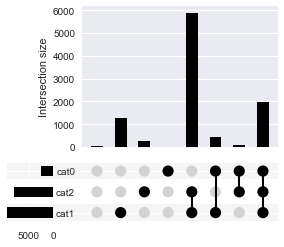

In [10]:
from upsetplot import generate_counts
example = generate_counts()
from upsetplot import plot
plt.style.use("seaborn")
plot(example)
plt.show()  

In [11]:
print(res)

NameError: name 'res' is not defined

<Figure size 576x576 with 0 Axes>

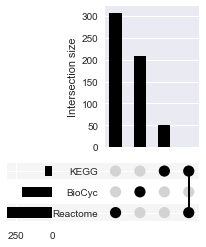

In [42]:
import upsetplot
categories = [["KEGG"], ["Reactome"], ["BioCyc"], ["KEGG", "Reactome"]]
data = [50, 307, 208, res["Quirós"]]
upset_data = upsetplot.from_memberships(categories, data)
fig = plt.figure(figsize=(8,8))

ax1 = plot(upset_data)
plt.show()

In [32]:
print(res.values())

dict_values([0.08034188034188035, 0.02890932982917214, 0.10465116279069768, 0.185473411154345, 0.10366972477064221, 0.11707317073170732])


In [65]:
biocyc_sig_paths_quiros = results_dicts["BioCyc"]["Quirós"]
human_cyc = process_paths(BioCyc_human_pathways)

In [69]:
biocyc_sig_cpds = [v for k, v in human_cyc.items() if k in biocyc_sig_paths_quiros]
biocyc_sig_cpds = [item for sublist in biocyc_sig_cpds for item in sublist]
biocyc_sig_cpds


In [73]:
biocyc_kegg_cpds = pd.read_csv("biocyc2kegg.txt", sep="\t")
biocyc_kegg_cpds = biocyc_kegg_cpds["Kegg"].tolist()

In [77]:
biocyc_vs_kegg = jaccard_similarity(kegg_sig_path_cpds["Stevens"], biocyc_kegg_cpds)
biocyc_vs_reactome = jaccard_similarity(reactome_sig_path_cpds["Stevens"], biocyc_kegg_cpds)

AttributeError: module 'matplotlib.pyplot' has no attribute 'yabel'

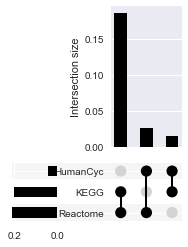

In [122]:
import upsetplot
categories = [["KEGG", "Reactome"], ["HumanCyc", "KEGG"], ["HumanCyc", "Reactome"]]
data = [res["Quirós"], biocyc_vs_kegg, biocyc_vs_reactome]
upset_data = upsetplot.from_memberships(categories, data)

plot(upset_data)
plt.savefig("upset_test.png", dpi=600)
plt.show()

In [105]:
x.make_grid()

{'matrix': GridSpec(9, 7)[6:9, 4:7],
 'shading': GridSpec(9, 7)[6:9, 0:7],
 'totals': GridSpec(9, 7)[6:9, 0:2],
 'gs': GridSpec(9, 7),
 'intersections': GridSpec(9, 7)[0:6, 4:7]}

<Figure size 219.5x288 with 0 Axes>

AttributeError: 'UpSet' object has no attribute '_cachedRenderer'

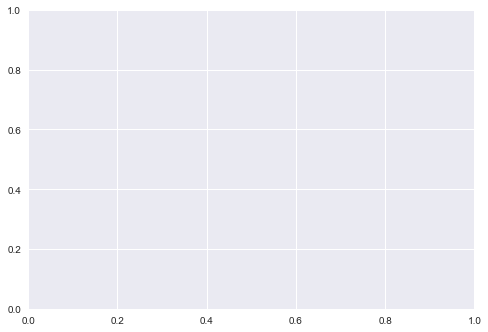

In [114]:
fig, ax = plt.subplots()
x = upsetplot.UpSet(upset_data)
axes = x.make_grid(x)
axes